In [1]:
import os
import csv
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf


In [2]:
def show_training_progress(history):
    """Visualize the evolution of training/validation metrics over epochs.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10, 5),sharex=True)
    
    ax1.plot(epochs, acc, 'g', label='Training')
    ax1.plot(epochs, val_acc, 'm--', label='Validation')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(epochs, loss, 'g')
    ax2.plot(epochs, val_loss, 'm--')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.grid(True)
    plt.tight_layout()


Data from Kaggle download via this [link](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification/data) and stored in the `data` directory.

In [3]:
# specify source data and destination for auto-labelling
data_path='data'
root_path='data_grouped'

# read the metadata file provided by Kaggle to get filenames and labels
training_metadata = pd.read_csv(os.path.join(data_path,'Training_set.csv'))

# delete destination if cell is re-run
if os.path.exists(root_path):
    shutil.rmtree(root_path)

os.mkdir(root_path)

# loop through all files and move files to new directories based on their labels.
for _, row in training_metadata.iterrows():
    destination_path = os.path.join(root_path, row['label'])
    if not os.path.exists(destination_path):
        os.mkdir(destination_path)
    file_origin= os.path.join(data_path,'train',row['filename'])
    shutil.copy(file_origin,destination_path)

In [4]:
training_metadata.describe()

,filename,label
count,6499,6499
unique,6499,75
top,Image_1.jpg,MOURNING CLOAK
freq,1,131


The number of images per label is on average 86, with some but not a lot of variance.  The status suggest we don't have to worry too much about class imbalance during training.

In [5]:
training_metadata['label'].value_counts().describe()

count     75.000000
mean      86.653333
std        9.267049
min       71.000000
25%       81.000000
50%       86.000000
75%       92.000000
max      131.000000
Name: count, dtype: float64

Define the data pipeline including image augmentation for the training set.

In [6]:
training_processing = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(scale=1./255),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2, fill_mode='nearest'),
    tf.keras.layers.RandomTranslation(0.2,0.2, fill_mode='nearest'),
    tf.keras.layers.RandomZoom(0.2, fill_mode='nearest'),
])

validation_processing = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(scale=1./255),
])

training_data, validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    root_path,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.3,
    seed=1701,
    subset='both',
    interpolation='bilinear',
    verbose=True
)

class_names = training_data.class_names
num_classes = len(class_names)

training_data = (
    training_data
    .map(lambda x, y: (training_processing(x), y),
        num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

validation_data = (
    validation_data
    .map(lambda x,y: (validation_processing(x), y),
        num_parallel_calls=tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE)
)


Found 6499 files belonging to 75 classes.
Using 4550 files for training.
Using 1949 files for validation.


View a handful of images from the validation set.  Switch to the training set to also see the effects of image augmentation.

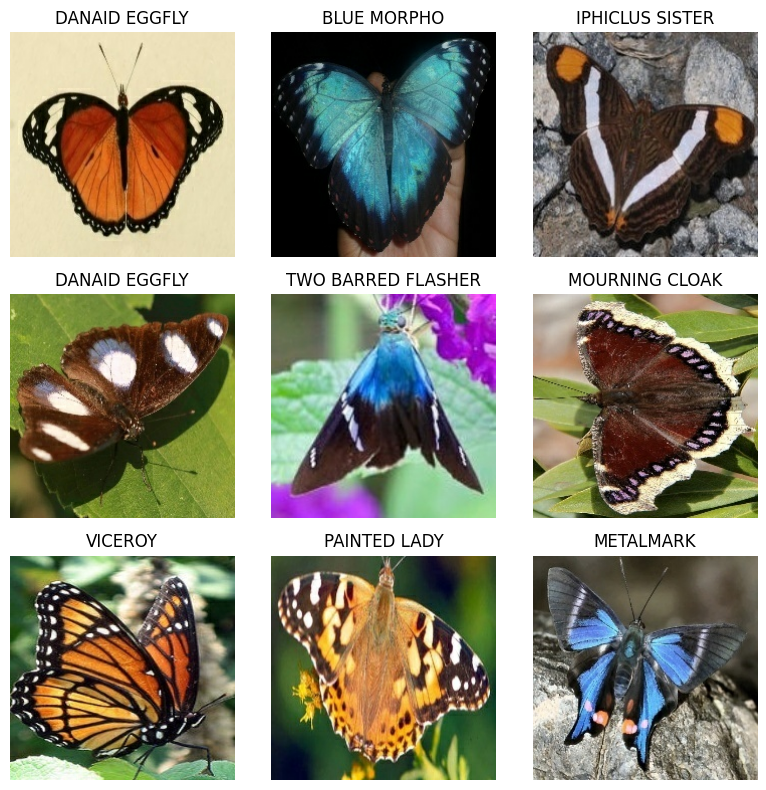

In [7]:
plt.figure(figsize=(8, 8))
for images, labels in validation_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.tight_layout()

Tried several models from scratch but couldn't get much better than 60% accuracy.

In [8]:
diy_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

Instead went to fine-tuning some well known architectures.

In [9]:
base_model = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
for layer in base_model.layers[:-10]:
    layer.trainable = False

model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [10]:
# model = diy_model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    training_data,
    epochs=300,
    validation_data=validation_data
)

Epoch 1/300


I0000 00:00:1713058653.674974   64645 service.cc:145] XLA service 0x7ff15c0d3350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713058653.675032   64645 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
I0000 00:00:1713058657.412968   64882 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_28280', 540 bytes spill stores, 540 bytes spill loads

I0000 00:00:1713058657.422425   64902 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_28280', 544 bytes spill stores, 544 bytes spill loads



  1/143 ━━━━━━━━━━━━━━━━━━━━ 38:35 16s/step - accuracy: 0.0000e+00 - loss: 4.5572

I0000 00:00:1713058663.371908   64645 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


141/143 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0810 - loss: 4.1081

I0000 00:00:1713058672.423563   65093 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_28280', 512 bytes spill stores, 512 bytes spill loads

I0000 00:00:1713058672.456638   65083 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_28280', 516 bytes spill stores, 516 bytes spill loads



143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 181ms/step - accuracy: 0.0820 - loss: 4.0999 - val_accuracy: 0.2966 - val_loss: 2.7562
Epoch 2/300
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.2413 - loss: 2.9246 - val_accuracy: 0.4602 - val_loss: 2.0360
Epoch 3/300
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.3403 - loss: 2.4124 - val_accuracy: 0.5490 - val_loss: 1.5955
Epoch 4/300
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.4272 - loss: 2.0348 - val_accuracy: 0.6280 - val_loss: 1.2886
Epoch 5/300
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.5028 - loss: 1.7273 - val_accuracy: 0.6337 - val_loss: 1.1872
Epoch 6/300
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.5304 - loss: 1.5809 - val_accuracy: 0.6937 - val_loss: 1.0525
Epoch 7/300
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.5711 - loss: 1.4503 - val_accuracy: 0.7209 - val_loss: 0.9261
Epoch 8/300
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.5920 - loss: 1.3709 - val_accura

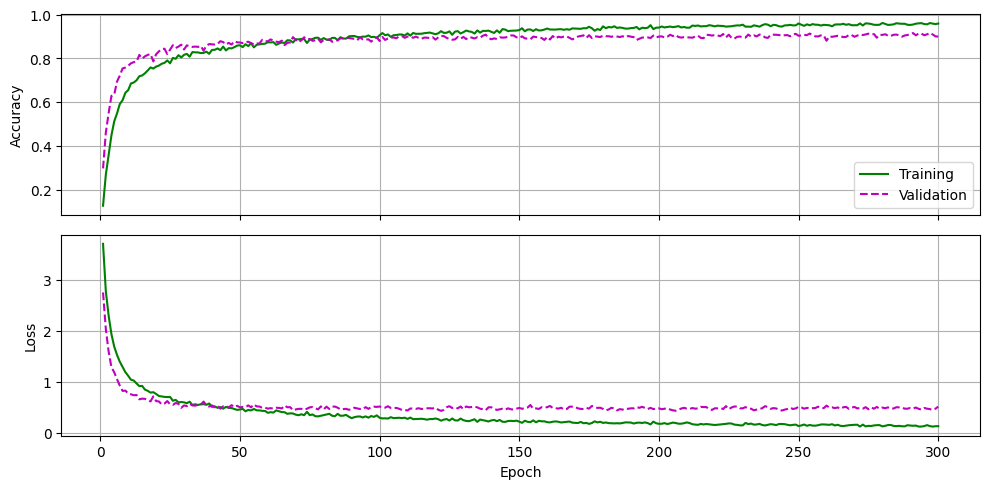

In [11]:
show_training_progress(history)

Now we can evaluate the test set and predict the classes.

In [12]:
testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_path,'test'),
    labels=None,
    label_mode=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    verbose=True
)
files = testing_data.file_paths

testing_processing = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(scale=1./255),
])

testing_data = (
    testing_data
    .map(lambda x: (testing_processing(x)),
        num_parallel_calls=tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE)
)


predictions = model.predict(testing_data)
predictions = np.argmax(predictions, axis=1)


Found 2786 files.
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step


A little bit of reordering to output predictions in order of the filename number which is different from the order of the files in the drive.

In [13]:
output = []
for i, category_number in enumerate(predictions):
    file = os.path.basename(files[i])
    file_number = int("".join(c for c in file if c.isnumeric()))
    category = class_names[category_number]
    output.append((file_number, file, category))

In [14]:
sorted_predictions = [(x[1],x[2]) for x in sorted(output)]